In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
from tqdm import tqdm

In [4]:
class KineticMonteCarloSelective:
    def __init__(self, lattice_size, T, e_ads, e_diff, e_int_abs, time_array, time_factor, process = 'adsorption'):
        self.lattice_size = lattice_size
        self.lattice = np.zeros((lattice_size, lattice_size))
        self.T = T
        self.e_ads = e_ads
        self.e_diff = e_diff
        self.e_int_abs = e_int_abs
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time = time_array[0]
        self.time_array = time_array
        self.occupancy = {t: None for t in self.time_array}
        self.events_count = {"adsorption": 0, "diffusion": 0}
        self.adsorption = []
        self.diffusion = []
        self.process = process

    def pick_random_site(self):
        i, j = np.random.randint(0, self.lattice_size, size=2)
        return i, j

    def count_occupied_neighbors(self, site):
        neighbors = 0
        i, j = site
        for ni, nj in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
            if 0 <= ni < self.lattice_size and 0 <= nj < self.lattice_size:
                neighbors += self.lattice[ni, nj]
        return neighbors

    def activation_energies(self, site):
        n_ij = self.count_occupied_neighbors(site)
        ads = self.e_int_abs * n_ij + self.e_ads
        return ads

    def calculate_transition_rates(self, site):
        E_ads= self.activation_energies(site)
        k_ads = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T)) if self.process in ['adsorption', 'both'] else 0
        k_diff = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-self.e_diff / (self.k_b * self.T)) if self.process in ['diffusion', 'both'] else 0
        k_total = k_ads + k_diff
        return k_ads, k_diff, k_total

    def select_event(self, k_ads, k_diff):
        total_propensity = k_ads + k_diff
        r = np.random.rand() * total_propensity
        if r < k_ads:
            return "adsorption"
        else:
            return "diffusion"

    def run_simulation(self):
        end_time = self.time_array[-1]
        total_time = end_time - self.time_array[0]
        last_percentage = 0
        i=0
            

        while self.time < end_time:
            for t in self.time_array:
                if self.occupancy[t] is None and self.time >= t:
                    self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

            site = self.pick_random_site()
            k_ads, k_diff, k_total = self.calculate_transition_rates(site)

            if k_total == 0:
                break  # No more events possible

            
            delta_t = (-np.log(np.random.rand()) / k_total)/self.factor
            self.time += delta_t
            event_type = self.select_event(k_ads, k_diff)

            if event_type == "adsorption":
                self.lattice[site] = 1
                self.events_count["adsorption"] += 1
            elif event_type == "diffusion":
                self.events_count["diffusion"] += 1
                if self.lattice[site] == 1:
                    neighbors = [
                        (site[0] + dx, site[1] + dy)
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]
                        if 0 <= site[0] + dx < self.lattice_size and 0 <= site[1] + dy < self.lattice_size
                    ]
                    vacant_neighbors = [s for s in neighbors if self.lattice[s] == 0]
                    if vacant_neighbors:
                        new_site = vacant_neighbors[np.random.randint(len(vacant_neighbors))]
                        self.lattice[site], self.lattice[new_site] = 0, 1

            self.adsorption.append(self.events_count["adsorption"])
            self.diffusion.append(self.events_count["diffusion"])

        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = np.sum(self.lattice == 1) / (self.lattice_size ** 2) * 100

        return self.occupancy

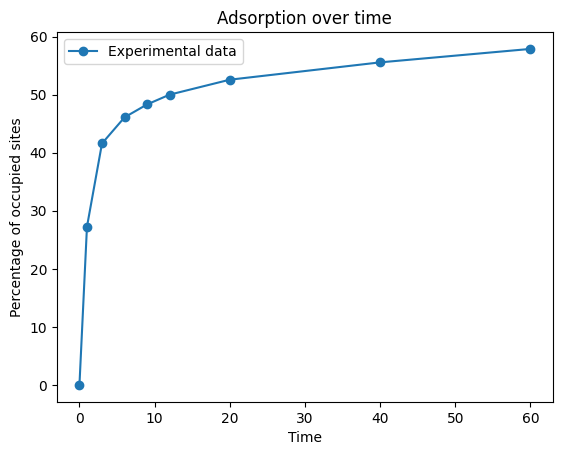

In [5]:
data = pd.read_csv('Datos recogidos.csv')
t = np.array([1,3,6,9,12,20,40,60])

for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.dropna(inplace=True)
data.iloc[3] = data.iloc[3] * 10
data.reset_index(drop=True, inplace=True)
data.insert(0, 'T0', 0)


time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])

plt.plot(time_array, data.iloc[5], marker='o', label='Experimental data')
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.legend()
plt.show()

Saturation:  0.0 %
{'adsorption': 3345, 'diffusion': 0}
Saturation:  48.61224489795919 %


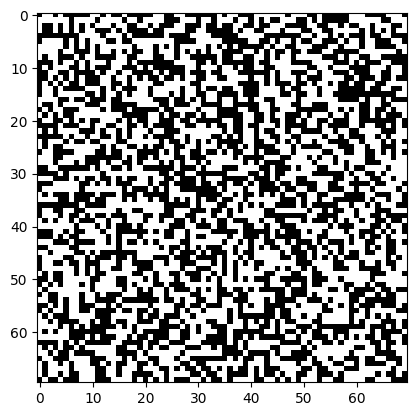

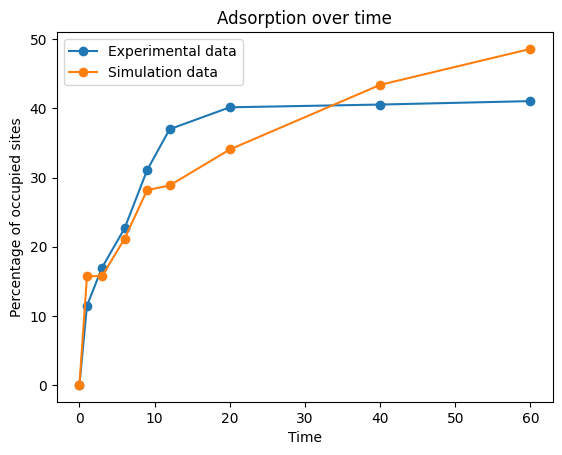

Mean Squared Error (MSE): 22.109811703441693


In [35]:
lattice_size = 70
T = 300
e_ads = 0.14
e_diff = 0.294
e_int_abs = 0.059
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
time_factor = 1e-7
process = 'adsorption'

KMC = KineticMonteCarloSelective(lattice_size=lattice_size, T=T, e_ads=e_ads, e_diff=e_diff, e_int_abs=e_int_abs,time_array=time_array, time_factor=time_factor, process=process)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")

occupancy = KMC.run_simulation()
print(KMC.events_count)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")
plt.imshow(KMC.lattice, cmap='binary')
plt.show()

exp_data = data.iloc[3]
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0

plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")


In [38]:
base_params = {
    "T": 300,  
    "e_ads": 0.14,  
    "e_int_abs": 0.059
}
variability = 0.1

In [39]:
low_e_ads = min(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))
high_e_ads = max(base_params["e_ads"] * (1 - variability), base_params["e_ads"] * (1 + variability))

low_e_int_abs = min(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))
high_e_int_abs = max(base_params["e_int_abs"] * (1 - variability), base_params["e_int_abs"] * (1 + variability))

In [40]:
# Definir número de iteraciones
N_CALLS = 200

# Inicializar barra de progreso
progress_bar = tqdm(total=N_CALLS, desc="Optimización Bayesiana en Progreso", position=0)

# Variables para almacenar el mejor resultado
best_params = None
best_error = float("inf")

def loss_function(params):
    global start_time, best_params, best_error
    
    # Desempaquetar parámetros
    e_ads, e_int_abs, lattice_size, T = params  

    # Ejecutar el modelo KMC
    kmc_model = KineticMonteCarloSelective(
        lattice_size=lattice_size, T=T, e_ads=e_ads, e_diff=0, e_int_abs=e_int_abs, time_factor=1e-7,
        time_array=np.array([0, 1, 3, 6, 9, 12, 20, 40, 60]), process='adsorption'
    )
    kmc_model.run_simulation()

    # Calcular error
    simulated_data = np.array(list(kmc_model.occupancy.values()))
    error = np.mean((simulated_data - exp_data) ** 2)

    # Actualizar mejores parámetros si se encuentra un menor error
    if error < best_error:
        best_error = error
        best_params = params
        print(f"🟢 Nuevo mejor error: {best_error:.6f} con parámetros {best_params}")

    # Calcular tiempos estimados
    elapsed_time = time.time() - start_time
    avg_time_per_iter = elapsed_time / (progress_bar.n + 1)
    estimated_time_left = avg_time_per_iter * (N_CALLS - progress_bar.n - 1)

    # Agregar información en la barra de progreso
    progress_bar.set_postfix({
        "Tiempo transcurrido": f"{elapsed_time:.2f} s",
        "Tiempo restante": f"{estimated_time_left:.2f} s",
        "Mejor error": f"{best_error:.6f}"
    })
    
    progress_bar.update(1)

    return error

# Definir espacio de búsqueda
space = [
    Real(low_e_ads, high_e_ads, name="e_ads"),
    Real(low_e_int_abs, high_e_int_abs, name="e_int_abs"),
    Integer(60, 100, name="lattice_size"),
    Real(280, 350, name="T")
]

# Iniciar optimización
start_time = time.time()
result = gp_minimize(loss_function, space, n_calls=N_CALLS, random_state=42)
progress_bar.close()

# Finalizar optimización
end_time = time.time()
print("\n✅ Optimización completada")
print("🔹 Parámetros óptimos encontrados:", best_params)
print("🔹 Error mínimo encontrado:", best_error)
print(f"⏳ Tiempo total de ejecución: {end_time - start_time:.2f} segundos")

Optimización Bayesiana en Progreso:   2%|▏         | 4/200 [00:00<00:12, 15.45it/s, Tiempo transcurrido=0.26 s, Tiempo restante=12.55 s, Mejor error=62.910404]

🟢 Nuevo mejor error: 79.074582 con parámetros [0.14830320363208654, 0.055264530520420733, np.int64(91), 321.7795110562541]
🟢 Nuevo mejor error: 62.910404 con parámetros [0.15227947585244103, 0.05310918943692397, np.int64(100), 323.2237056739402]


Optimización Bayesiana en Progreso:   4%|▍         | 9/200 [00:00<00:11, 16.56it/s, Tiempo transcurrido=0.59 s, Tiempo restante=11.29 s, Mejor error=16.375245]

🟢 Nuevo mejor error: 19.985965 con parámetros [0.1371961072080272, 0.053650654825920664, np.int64(99), 296.2939938301213]
🟢 Nuevo mejor error: 16.375245 con parámetros [0.13906936101094347, 0.06324729679948858, np.int64(87), 311.534947637868]


Optimización Bayesiana en Progreso:   5%|▌         | 10/200 [00:00<00:11, 17.23it/s, Tiempo transcurrido=0.87 s, Tiempo restante=14.86 s, Mejor error=11.684169]

🟢 Nuevo mejor error: 11.684169 con parámetros [0.13789013618560533, 0.06374872090866346, np.int64(87), 310.45329190401736]


Optimización Bayesiana en Progreso:  22%|██▏       | 44/200 [00:10<01:01,  2.55it/s, Tiempo transcurrido=10.65 s, Tiempo restante=37.75 s, Mejor error=9.754787] 

🟢 Nuevo mejor error: 9.754787 con parámetros [0.15400000000000003, 0.05606632375433108, np.int64(100), 312.4411769090286]


Optimización Bayesiana en Progreso:  61%|██████    | 122/200 [01:05<01:30,  1.16s/it, Tiempo transcurrido=65.74 s, Tiempo restante=42.03 s, Mejor error=9.754787]/Users/gtorres/Desktop/proyecto/.venv/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.15400000000000003, 0.0531, np.int64(60), 280.0] before, using random point [0.13041082767882325, 0.05685006366755271, np.int64(93), 293.4118709947544]
  warnings.warn(
Optimización Bayesiana en Progreso:  92%|█████████▏| 183/200 [02:51<00:38,  2.28s/it, Tiempo transcurrido=171.41 s, Tiempo restante=15.92 s, Mejor error=8.849446]

🟢 Nuevo mejor error: 8.849446 con parámetros [0.14856189030985617, 0.062461289895818, np.int64(77), 305.6169709539719]


Optimización Bayesiana en Progreso: 100%|█████████▉| 199/200 [03:31<00:02,  2.52s/it, Tiempo transcurrido=211.08 s, Tiempo restante=1.06 s, Mejor error=8.307772] 

🟢 Nuevo mejor error: 8.307772 con parámetros [0.12600000000000003, 0.0649, np.int64(67), 289.2063147050893]


Optimización Bayesiana en Progreso: 100%|██████████| 200/200 [03:36<00:00,  1.08s/it, Tiempo transcurrido=213.69 s, Tiempo restante=0.00 s, Mejor error=8.307772]


✅ Optimización completada
🔹 Parámetros óptimos encontrados: [0.12600000000000003, 0.0649, np.int64(67), 289.2063147050893]
🔹 Error mínimo encontrado: 8.307771886618907
⏳ Tiempo total de ejecución: 216.23 segundos


Mean Squared Error (MSE): 9.93565431415325


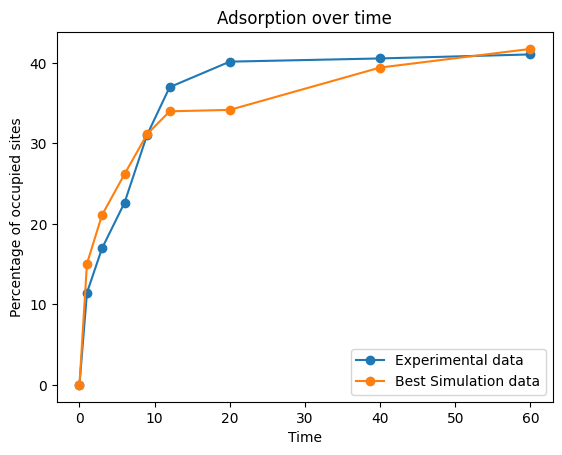

In [72]:
# Ejecutar el modelo KMC con los mejores parámetros encontrados
best_e_ads, best_e_int_abs, best_lattice_size, best_T = best_params

best_KMC = KineticMonteCarloSelective(
    lattice_size=best_lattice_size, T=best_T, e_ads=best_e_ads, e_diff=0, e_int_abs=best_e_int_abs, 
    time_factor=1e-7, time_array=time_array, process='adsorption'
)
best_occupancy = best_KMC.run_simulation()

# Convertir los resultados de la simulación a un array
best_simulated_data = np.array(list(best_occupancy.values()))
best_simulated_data[0] = 0

mse = np.mean((np.array(exp_data) - np.array(best_simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")

# Graficar los datos experimentales y los datos simulados
plt.plot(time_array, exp_data, marker='o', label='Experimental data')
plt.plot(time_array, best_simulated_data, marker='o', label='Best Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()



Saturation:  0.0 %
{'adsorption': 1766, 'diffusion': 0}
Saturation:  30.04081632653061 %


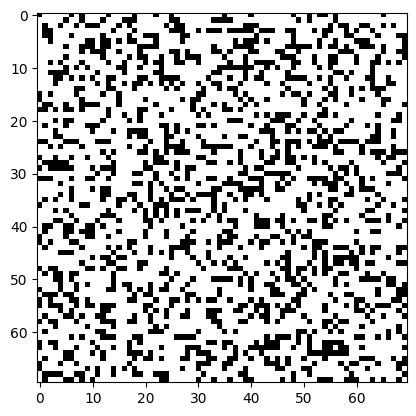

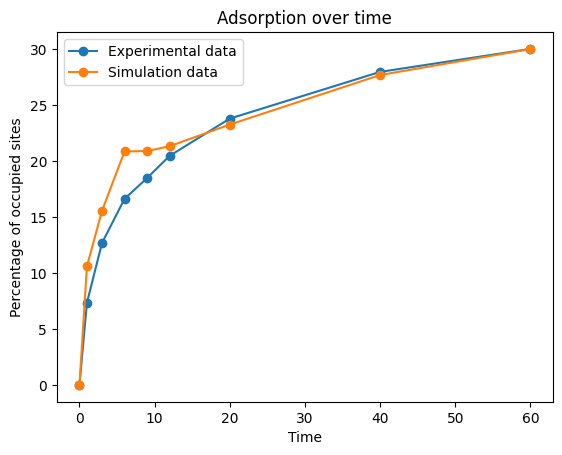

Mean Squared Error (MSE): 4.867105190323915


In [11]:
lattice_size = 70
T = 300
e_ads = 0.19
e_diff = 0.294
e_int_abs = 0.059
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
time_factor = 1e-7
process = 'adsorption'

KMC = KineticMonteCarloSelective(lattice_size=lattice_size, T=T, e_ads=e_ads, e_diff=e_diff, e_int_abs=e_int_abs,time_array=time_array, time_factor=time_factor, process=process)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")

occupancy = KMC.run_simulation()
print(KMC.events_count)
print("Saturation: ",np.sum(KMC.lattice)/(lattice_size**2)*100, "%")
plt.imshow(KMC.lattice, cmap='binary')
plt.show()

exp_data = data.iloc[0]
simulated_data = np.array(list(occupancy.values()))
simulated_data[0] = 0

plt.plot(time_array,exp_data,marker='o', label='Experimental data')
plt.plot(time_array,np.array(simulated_data), marker='o', label='Simulation data')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Percentage of occupied sites")
plt.title("Adsorption over time")
plt.show()

mse = np.mean((np.array(exp_data) - np.array(simulated_data)) ** 2)
print(f"Mean Squared Error (MSE): {mse}")
